# Solve the constrained monitoring problem by state-augmentation with augmenting dual multipliers sampled from a diffusion model.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device; ', device)

FIG_ROWSIZE = 6
FIG_COLSIZE = 6
FIG_FONTSIZE = 14
SCATTER_POINT_SIZE = 5.0

device;  cuda:0


### Define the environment, agent and policies.

In [2]:
from core.env import BaseEnv
from core.policy import Agent, OraclePolicy, LambdaSampler
from core.config import NUM_STATES, NUM_EPISODES, NUM_TIMESTEPS, LAMBDAS_MAX, DIFFUSE_N_SAMPLES

env = BaseEnv(device=device)
oracle = OraclePolicy(device=device)
agent = Agent(device=device)

In [3]:
# from core.config import LAMBDAS_MAX, DIFFUSE_N_SAMPLES
# n_samples = DIFFUSE_N_SAMPLES
# n_constraints = len(env.states) - 1
# lambdas_0 = LAMBDAS_MAX * torch.rand(size = (n_samples, n_constraints), dtype = torch.float32, device = device)

### Rollout episodes of the MDP with fixed dual multipliers (i.e., unconstrained MDP with fixed weighted rewards)

In [4]:
from collections import defaultdict

def eval_monitoring(agent, env, n_episodes, n_timesteps, lambdas_sampler, lr_lambdas = 0.):
    all_variables_across_all_episodes = []
    for episode in tqdm.tqdm(range(n_episodes)):
        # state = env.reset()
        # lambdas_0 = lambdas_sampler.sample(n_samples = 1).squeeze(0)

        all_variables = defaultdict(list)
        for timestep in range(n_timesteps): # Limit timesteps as episode
            state = env.reset()
            lambdas_0 = lambdas_sampler.sample(n_samples = 1).squeeze(0)
            action = agent.select_action(augmented_state=(state, lambdas_0))
            new_state, rewards, _ = env.step(action=action)

            vars = {'timestep': timestep,
                    'old_state': (state, *lambdas_0.tolist()),
                    'new_state': (new_state, *lambdas_0.tolist()),
                    'action': action,
                    'rewards': rewards.tolist()
                    }
            
            for key in vars.keys():
                all_variables[key].append(vars[key])

            state = new_state

        all_variables_across_all_episodes.append({'episode': episode, 'variables': all_variables})

    return all_variables_across_all_episodes


env = BaseEnv(init_state=torch.randint(low=0, high=NUM_STATES, size = (1,)), device=device)
agent = Agent(device=device)
lambdas_sampler = LambdaSampler(lambdas_max=LAMBDAS_MAX, n_lambdas=len(env.states) - 1, device=device)

all_metrics = eval_monitoring(agent=agent,
                              env=env,
                              n_episodes=NUM_EPISODES,
                              n_timesteps=NUM_TIMESTEPS,
                              lambdas_sampler=lambdas_sampler
                              )

100%|██████████| 100/100 [00:02<00:00, 45.01it/s]


### Visualize optimal deterministic policies

0.6594
color.values.min() = 1.0
color.values.max() = 2.0
0.6712
color.values.min() = 0.0
color.values.max() = 1.0
0.6694
color.values.min() = 0.0
color.values.max() = 2.0


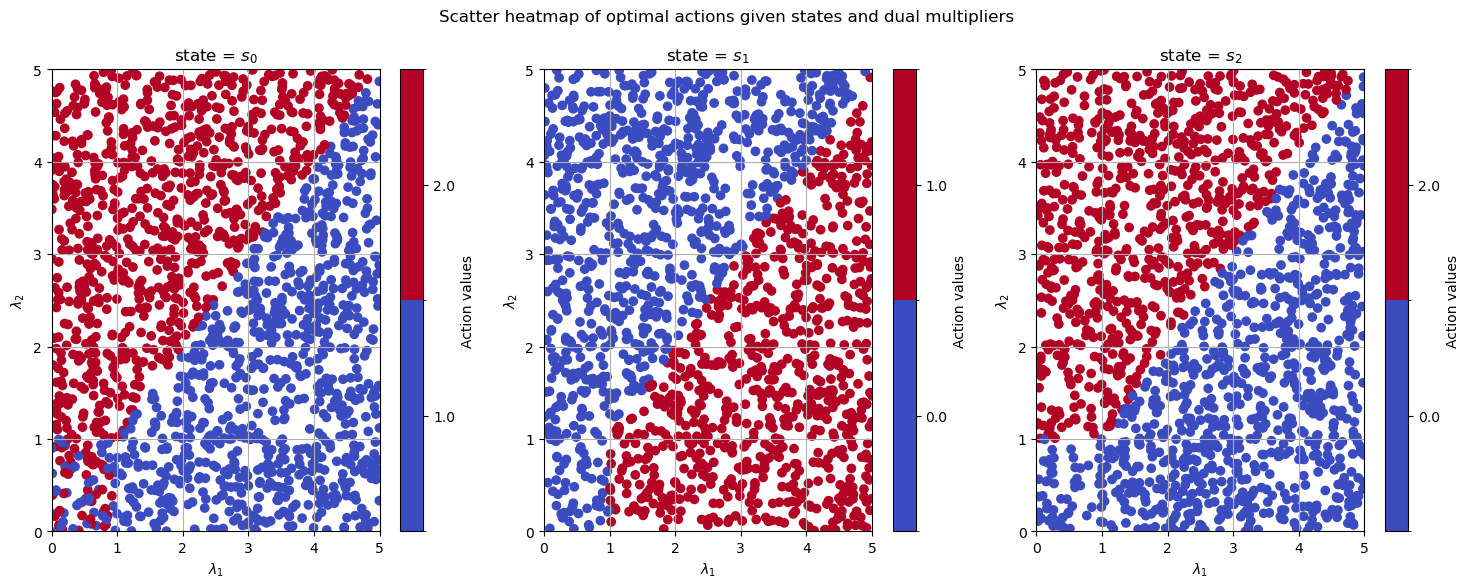

2.0


In [5]:
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm

def get_color_mapping(color_values, boundaries = None):

    # Normalize color values to [0, 1]
    print(f'color.values.min() = {color_values.min()}')
    print(f'color.values.max() = {color_values.max()}')

    # Use a colormap
    cmap = plt.get_cmap('coolwarm')

    if boundaries is None:
        norm = plt.Normalize(color_values.min(), color_values.max())
    else:
        norm = BoundaryNorm(boundaries, cmap.N)  # Create a norm based on boundaries

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # This is important for the colorbar

    return sm, cmap

# Collect all augmented states and actions #
all_aug_states = []
all_actions = []
all_rewards = []
for episode, metrics in enumerate(all_metrics):
    aug_states = torch.tensor(metrics['variables']['old_state']).T.detach().cpu().numpy()
    actions = torch.tensor(metrics['variables']['action']).unsqueeze(0).detach().cpu().numpy()
    rewards = torch.tensor(metrics['variables']['rewards']).T.detach().cpu().numpy()

    all_aug_states.append(aug_states)
    all_actions.append(actions)
    all_rewards.append(rewards)

all_aug_states = np.stack(all_aug_states, axis = -1)
all_actions = np.stack(all_actions, axis = -1)
all_rewards = np.stack(all_rewards, axis = -1)

# print('all_aug_states: ', all_aug_states.shape)
# print('all_actions: ', all_actions.shape)

valid_idx_fraction = 0
fig, axs = plt.subplots(1, NUM_STATES, figsize = (NUM_STATES * FIG_COLSIZE, FIG_ROWSIZE))

for state in range(NUM_STATES):
    cond = all_aug_states[0] == state
    select_aug_states = np.where(cond, all_aug_states, np.nan)
    select_actions = np.where(cond, all_actions, np.nan)
    print(np.mean(np.isnan(select_aug_states)))
    valid_idx_fraction += np.mean(np.isnan(select_aug_states)).item()

    # print('select_actions.shape: ', select_actions.shape)
    # print('select_actions[filtered].shape: ', select_actions[~np.isnan(select_actions)].shape)
    # print('select_aug_states[1][filtered].shape: ', select_aug_states[1][~np.isnan(select_aug_states[1])].shape)
    # print('select_aug_states[2][filtered].shape: ', select_aug_states[2][~np.isnan(select_aug_states[2])].shape)

    select_actions = select_actions[~np.isnan(select_actions)]
    select_lambdas = np.stack((select_aug_states[1][~np.isnan(select_aug_states[1])], select_aug_states[2][~np.isnan(select_aug_states[2])]), axis = 0)

    if state == 1:
        pass
        # select_actions = np.random.randint(low = 0, high = NUM_STATES, size = select_actions.size)

    cmap_boundaries = np.linspace(start=select_actions.min(), stop=select_actions.max(), num = np.unique(select_actions).size + 1) # range(NUM_STATES) # None
    
    if cmap_boundaries is not None:
        cmap_ticks = []
        for i in range(len(cmap_boundaries)-1):
            cmap_ticks.append((cmap_boundaries[i] + cmap_boundaries[i+1])/2)
        cmap_ticks = np.array(cmap_ticks)

        # print('cmap_bound:',  cmap_boundaries)
        cmap_ticklabels = np.unique(select_actions)

    sm, cmap = get_color_mapping(select_actions, boundaries=cmap_boundaries)

    axs[state].scatter(x = select_lambdas[0].flatten(), y = select_lambdas[1].flatten(), c = select_actions, cmap = cmap)
    cbar = plt.colorbar(ax = axs[state], mappable=sm, label = 'Action values')
    if cmap_boundaries is not None:
        # cbar.set_ticks(cmap_boundaries)
        cbar.set_ticks(cmap_ticks)
        cbar.set_ticklabels(cmap_ticklabels)

    axs[state].set_xlabel(r'$\lambda_1$')
    axs[state].set_ylabel(r'$\lambda_2$')
    axs[state].set_xlim([0, LAMBDAS_MAX])
    axs[state].set_ylim([0, LAMBDAS_MAX])
    axs[state].grid(True)

    axs[state].set_title(r'state = $s_{}$'.format(state))

plt.suptitle('Scatter heatmap of optimal actions given states and dual multipliers')

plt.show(fig)
print(valid_idx_fraction)


Show that sampling $\lambda \sim \mathcal{U}(0, \lambda_{\max})$ does not yield an optimal hyperpolicy.

In [32]:
print(r'Reward slacks expectation over U(0, \lambda_{\max})$ (positive is good): ', all_rewards.mean(axis = (1, 2)) - np.array(agent.policy_net.c))

best_obj_and_constraints = [(np.max(all_rewards[i].flatten()), np.argmax(all_rewards[i].flatten())) for i in range(len(all_rewards))]
rewards = []
for (val, idx) in best_obj_and_constraints:
    temp = np.array([all_rewards[_].flatten()[idx] for _ in range(len(all_rewards))])
    rewards.append(temp)

rewards = np.stack(rewards, axis = -1)
print(r'Best rewards attained: ',  rewards)

feasibility_mask = ( (all_rewards - np.expand_dims(agent.policy_net.c, axis = (1, 2)))[1] >=0 ) * ( (all_rewards - np.expand_dims(agent.policy_net.c, axis = (1, 2)))[2] >=0 )
assert feasibility_mask.any() == False
print("No deterministic policy is strictly feasible.")

Reward slacks expectation over U(0, \lambda_{\max})$ (positive is good):  [ 0.01866667 -0.00773333 -0.01093333]
Best rewards attained:  [[1 0 0]
 [0 1 0]
 [0 0 1]]
No deterministic policy is strictly feasible.


### Compute importance sampling RN-Density
The RN-density is given by a $\tau$-scaled Lagrangian exponentiated, i.e., $e^{-\tau \mathcal{L}_{\lambda}(\theta^\star)}$ where $\tau \in (0, \infty)$ is the strength of KL Divergence to the dual multiplier sampling distribution.

## Create a VP-SDE object for the uncontrolled process

In [ ]:
from core.config import DIFFUSION_STEPS
from core.sde import VPSDE

diffusion_steps = DIFFUSION_STEPS  # Number of steps in the diffusion process

beta_min = 0.1
beta_max = 20
betas = torch.linspace(beta_min / diffusion_steps, beta_max / diffusion_steps, diffusion_steps).to(device=device)

alphas = 1 - betas
baralphas = torch.cumprod(alphas, dim = 0)

sde = VPSDE(N=diffusion_steps, beta_min = beta_min, beta_max = beta_max, beta_schedule='linear', device=device)

## Diffusion Network

Now we define a pytorch network that will learn to predict the noise component from noised data.

In [ ]:
import torch.nn as nn


## Unconditional FCNN diffusion model
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
    
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val
    

## Conditional Linear diffusion model
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x: torch.Tensor, y: torch.Tensor):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out # t + Graph

        out = F.softplus(out)
        return out
    
        
class ConditionalLinearModel(nn.Module):
    def __init__(self, nsteps, nfeatures: int, nblocks: int = 2, nunits: int = 128):
        super(ConditionalLinearModel, self).__init__()
        self.nsteps = nsteps
        self.inblock = ConditionalLinear(nfeatures, nunits, nsteps)
        # self.lin2 = ConditionalLinear(128, 128, nsteps)
        # self.lin3 = ConditionalLinear(128, 128, nsteps)
        self.midblock = nn.ModuleList([ConditionalLinear(nunits, nunits, nsteps) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor,
                edge_index = None, edge_weight = None, transmitters_index = None):
        val = self.inblock(x, t)
        for midblock in self.midblock:
            val = midblock(val, t)
        val = self.outblock(val)
        return val

## Visualize a learned score gradient field.

In [ ]:
# from utils.plot_helper_utils import hdr_plot_style
# hdr_plot_style()


# def make_score_model(sde, noise_model, controller = None, accel_factor = 1, DEBUG = False):
#     def score_fn(x, t):
#         # timestep = sde.timestep(t)
#         if torch.is_floating_point(t): # cts time
#             timestep = sde.timestep(t).to(torch.long)
#             if DEBUG:
#                 print(f'Mapped cts time {t} to discrete time {timestep}.')
#         else:
#             timestep = t.to(torch.long)
#         model_timestep = timestep / (sde.N - 1) * (accel_factor * sde.N - 1)
#         noise_pred = noise_model(x, model_timestep.to(torch.long))
#         score, _ = sde.score_fnc_to_noise_pred(timestep=timestep, score=None, noise_pred=noise_pred)

#         if controller is not None:
#             u = controller(x, timestep)
#             score = score - u / torch.sqrt(sde.discrete_betas[timestep])
        
#         return score
    
#     return score_fn


# def make_noise_model(sde, noise_model, accel_factor = 1, DEBUG = False):
#     def noise_fn(x, t):
#         # timestep = sde.timestep(t)
#         if torch.is_floating_point(t): # cts time
#             timestep = sde.timestep(t).to(torch.long)
#             if DEBUG:
#                 print(f'Mapped cts time {t} to discrete time {timestep}.')
#         else:
#             timestep = t.to(torch.long)
#         model_timestep = timestep / (sde.N - 1) * (accel_factor * sde.N - 1)
#         noise_pred = noise_model(x, model_timestep.to(torch.long))
        
#         return noise_pred
    
#     return noise_fn


# def plot_gradients(model, data, plot_scatter=True, plot_timestep = 1, is_noise_model = False, axs = None):
#     timestep = plot_timestep
#     xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)

#     scores = model(torch.tensor(xx).float().to(device), timestep/(DIFFUSION_STEPS-1) * torch.ones(size = (xx.shape[0], 1)).to(device)).detach().cpu()
#     if is_noise_model:
#         scores = (-1/(1 - baralphas[timestep])**0.5 * scores).detach().cpu()
    
#     scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
#     scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

#     if axs is None:
#         # Perform the plots
#         plt.figure(figsize=(16,12))
#         if (plot_scatter):
#             plt.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
#         plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
#         plt.xlim(-3, 3)
#         plt.ylim(-3, 3)
#         plt.title(f'Timestep {timestep}')

#     else:
#         if (plot_scatter):
#             axs.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
#         axs.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
#         axs.set_xlim(-3, 3)
#         axs.set_ylim(-3, 3)
#         axs.set_title(f'Timestep {timestep}')


# # def plot_gradients_v2(score_model, data, plot_scatter=True, plot_timestep = 1):
# #     timestep = plot_timestep
# #     xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# #     scores = score_model(torch.tensor(xx).float().to(device), timestep/(DIFFUSION_STEPS-1) * torch.ones(size = (xx.shape[0], 1)).to(device)).detach().cpu()
# #     scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
# #     scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# #     # Perform the plots
# #     plt.figure(figsize=(16,12))
# #     if (plot_scatter):
# #         plt.scatter(x = data[:, 0], y = data[:, 1], alpha = 0.3, color='red', edgecolor='white', s=40)
# #     plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
# #     plt.xlim(-3, 3)
# #     plt.ylim(-3, 3)

# score_model = make_score_model(sde=sde, noise_model=model, accel_factor=1, DEBUG = False)

# for t in range(1, DIFFUSION_STEPS, 99):
#     plot_gradients(score_model, X.cpu(), plot_timestep=t, is_noise_model=False)


# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Implement controlled SDE simulator.

In [ ]:
# def make_controller(sde, lambda_star):

#     def controller(x, t):
#         u_star = u_true(sde=sde, x=x, t=t, lambda_star=lambda_star)
#         return u_star
    
#     return controller


def forward(sde, x_0, t_0 = None, t_1 = None, controller = None, gamma = 1., no_sde_drift = False, is_backward = False, verbose = False):
    """ Simulate discretized SDE with optional control input from cts time \tau = t_0 until \tau = t_1. """
    dt = 1 / (sde.N - 1)
    if t_0 is None:
        t_0 = torch.ones_like(x_0)[:, 0:1] if is_backward else torch.zeros_like(x_0)[:, 0:1]
    else:
        t_0 = t_0

    t_1 = 1 - t_0 if t_1 is None else t_1
    dt = -dt if is_backward else dt

    with torch.no_grad():
        xt = [x_0.detach().cpu()]
        tt = [t_0.detach().cpu()]
        zt = [[None]]
        ut = [[None]]

        x = x_0.clone()
        t = t_0.clone()
        
        if is_backward:
            while torch.any(t > t_1):
                if verbose:
                    print('Reverse process timestep: ', sde.timestep(t[0]))

                rev_f, rev_G = sde.discretize(x, t) # G = \sigma_t * sqrt(dt)

                # beta_t = sde.beta_0 + t * (sde.beta_1 - sde.beta_0) # linear SDE
                # sigma_t = torch.sqrt(beta_t)

                f = 0 if no_sde_drift else -rev_f
                G = rev_G

                with torch.set_grad_enabled(True):
                    if controller is not None:
                        u = controller(x, t)
                        u[torch.isnan(u)] = 0.
                        # f = f + gamma * G**2  * u # control is already added
                    else:
                        u = None

                z = torch.randn_like(x)
                x = x + (t > t_1) * (f + G * z)
                t = t + (t > t_1) * dt

                xt += [x.detach().cpu()]
                tt += [t.detach().cpu()]
                zt += [z.detach().cpu()]
                if controller is not None:
                    ut += [u.detach().cpu()]

        else:
            while torch.any(t < t_1):
                if verbose:
                    print('Forward process timestep: ', sde.timestep(t[0]))
                f, G = sde.discretize(x, t) # G = \sigma_t * sqrt(dt)

                beta_t = sde.beta_0 + t * (sde.beta_1 - sde.beta_0) # linear SDE
                sigma_t = torch.sqrt(beta_t)

                f = 0 if no_sde_drift else f

                # timestep = (t / (sde.N - 1)).to(torch.long)
                # betas = sde.discrete_betas[timestep]
                # sigma_t = torch.sqrt(betas)

                with torch.set_grad_enabled(True):
                    if controller is not None:
                        u = controller(x, t)
                        u[torch.isnan(u)] = 0.
                        # f = f + gamma * (G / dt**0.5) * u * dt
                        f = f + gamma * G**2  * u
                    else:
                        u = None

                z = torch.randn_like(x)
                x = x + (t < t_1) * (f + G * z)
                t = t + (t < t_1) * dt

                xt += [x.detach().cpu()]
                tt += [t.detach().cpu()]
                zt += [z.detach().cpu()]
                if controller is not None:
                    ut += [u.detach().cpu()]

        if controller is not None:
            return xt, (tt, ut, zt)
        else:
            return xt, (tt, zt)
        

# BACKWARD = True
# timesteps = torch.randint(low = 0, high = sde.N - 1, size = (X.shape[0], 1), device = device)
# t = timesteps / (sde.N - 1)
    
# if BACKWARD:
#     t = torch.ones_like(t) 
#     X_0 = sde.prior_sampling(X.shape)
#     controller = score_model
#     diffusion_sde = sde.reverse(score_fn=controller)

# else:
#     t = torch.zeros_like(t) 
#     X_0 = X
#     controller = None
#     diffusion_sde = sde

# t = torch.full([X.shape[0], 1], 50/(sde.N-1)).to(device)
# t = torch.randint(low = 0, high=sde.N-1, size = t.size(), device = t.device) / sde.N-1

# Xgen_hist, Tgen_hist = forward(sde=diffusion_sde, x_0=X_0, t_0=t, controller=controller, gamma=1, is_backward=BACKWARD)
# controller = make_controller(sde=sde, lambda_star=lambda_star)
# Xgen_controlled_hist, Tgen_controlled_hist = forward(sde=sde, x_0=X, t_0=t, controller=controller, gamma=1)   

In [ ]:
# fig, axs = plt.subplots(1, 1, figsize = (1 * FIG_COLSIZE, 1 * FIG_ROWSIZE))

# axs.scatter(X_0[:, 0].cpu(), X_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.4, label = r'$\mathcal{N}(0, I)$ prior' if BACKWARD else 'Original data')
# axs.scatter(Xgen_hist[-1][:, 0].cpu(), Xgen_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.4, label = 'Uncontrolled generated data')

# # axs[1].scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5, label = 'Original data')
# # axs.scatter(Xgen_controlled_hist[-1][:, 0].cpu(), Xgen_controlled_hist[-1][:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="1", alpha=0.5, label = 'Controlled generated data')

# axs.grid(True)
# axs.legend(loc = 'best')

# plt.show()

Compute optimal dual multipliers and associated RN density.

In [ ]:
def get_train_optimal_lambdas_settings(eval_type):
    '''
    Retrieve training hyperparameters for finding optimal dual multipliers. 
    '''

    settings = {}
    if eval_type in ['linear']:
        settings['lr'] = 2e-1
        settings['niters'] = 200

    elif eval_type in ['abs-linear']:
        settings['lr'] = 5.
        settings['niters'] = 500

    elif eval_type == 'quadratic':
        settings['lr'] = 5e-1
        settings['niters'] = 200

    elif eval_type in ['pinned-measure', 'pinned-measure-single-lambda']:
        settings['lr'] = 5. # 1
        settings['niters'] = 300 # 500

    else:
        raise NotImplementedError

    return settings


def train_optimal_lambdas(lambdas_init, constraints, x_0, niters = 100, lr=1e-1, DEBUG = False, sgd_temperature = 1., sgd_temperature_decay = 0.99):
    '''
    Training loop to find the optimal dual multipliers and the associated change of measure. 
    '''

    lambdas = lambdas_init.clone().requires_grad_(True)
    all_lambdas = []
    all_dQ_star_div_dP = []
    all_Q_star_constraints = []

    with torch.no_grad():
        dQ_star_div_dP = optimal_change_of_measure(lambdas_star=lambdas, constraints=constraints, x_0=x_0)
        Q_star_constraints = (constraints(x_0) * dQ_star_div_dP.unsqueeze(-1)).mean(dim = 0)

        all_lambdas.append(lambdas.detach().clone())
        all_dQ_star_div_dP.append(dQ_star_div_dP.detach().clone())
        all_Q_star_constraints.append(Q_star_constraints.detach().clone())

    with torch.set_grad_enabled(True):
        for iter in range(niters):
            loss = (-lambdas * constraints(x_0)).sum(-1).exp().mean(dim = 0)
            loss.backward()

            with torch.no_grad():
                lambdas -= lr * lambdas.grad + sgd_temperature * torch.randn_like(lambdas)
                lambdas.data.clamp_(0)
            lambdas.grad.zero_()

            if (iter + 1) % 20 == 0 and DEBUG:
                print(f'iter: {iter} \t loss: {loss.item()} \t lambdas: {lambdas}')

            with torch.no_grad():
                dQ_star_div_dP = optimal_change_of_measure(lambdas_star=lambdas, constraints=constraints, x_0=x_0)
                Q_star_constraints = (constraints(x_0) * dQ_star_div_dP.unsqueeze(-1)).mean(dim = 0)

                all_lambdas.append(lambdas.detach().clone())
                all_dQ_star_div_dP.append(dQ_star_div_dP.detach().clone())
                all_Q_star_constraints.append(Q_star_constraints.detach().clone())

            sgd_temperature *= sgd_temperature_decay

    return all_lambdas, all_dQ_star_div_dP, all_Q_star_constraints


def optimal_change_of_measure(lambdas_star, constraints, x_0):
    return (-lambdas_star * constraints(x_0)).sum(-1).exp() / (-lambdas_star * constraints(x_0)).sum(-1).exp().mean(dim = 0, keepdim=True)